# Spooky Author Identification

## Agenda

 - [Dataset Overview](#dataset_ovrview) 
 - [Importing the libraries](#impl) 
 - [Loading the dataset](#ldl) 
 - [Structure of the Data](#sotd) 
 - [Data Visualization](#dv) 
 - [Data Preprocessing](#dp)
 - [Classification Algorithm](#calgo)
 - [Testing on Unlabeled data](#test)
 

<a id='dataset_ovrview'></a>

## 1) Dataset Overview

The Spooky Author Identification data set is uploaded on Kaggle as a part of Halloween theme challenge. 

The goal of this challenge is to predict the author of horror stories passages based on their writing. In particular, I will be analysing texts from Edgar Allan Poe, Mary Shelley, and HP Lovecraft with the goal to predict the probability for each excerpt to be written by one of those towering figures of harrowing horror.

The data comes in the shape of the traditional two files, training and test files. Each row contains a piece of horrible history from a specific author. 

The dataset consists of three columns,

     1) ID
     2) Text
     3) Author

<a id='impl'></a>

## 2) Importing the libraries

In [38]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
import matplotlib.pyplot as plt; plt.rcdefaults()
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.dummy import *
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import *
from sklearn.metrics import *
from spacy.lang.en import English
from cytoolz import *
from scipy.stats import wilcoxon
import spacy
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
color = sns.color_palette(sns.color_palette("Paired"))
nlp = spacy.load('en_core_web_sm')

<a id='ldl'></a>

## 3) Loading the dataset

In [3]:
train = pd.read_csv("../Data/train.csv")
test = pd.read_csv("../Data/test.csv")
print("Data Points in training dataset : ",train.shape[0])
print("Data Points in test dataset : ",test.shape[0])

('Data Points in training dataset : ', 19579)
('Data Points in test dataset : ', 8392)


<a id='sotd'></a>

## 4) Structure of the data

In [4]:
#checking first few rows of the training data. Checking the structure of training data
print("\n" +"Structure of Training Data" + "\n")
print(train.head())

#checking first few rows of the training data. Checking the structure of training data
#Test data is unlabeled, the author of the text is not mentioned. 
print("\n" +"Structure of Test Data"+ "\n")
print(test.head())

#checking for NULL values in training data 
print("\n" + "Null values in training dataset")
print(train.isnull().sum().sum())
print("\n" + "Null values in test dataset") 
print(test.isnull().sum().sum())


Structure of Training Data

        id                                               text author
0  id26305  This process, however, afforded me no means of...    EAP
1  id17569  It never once occurred to me that the fumbling...    HPL
2  id11008  In his left hand was a gold snuff box, from wh...    EAP
3  id27763  How lovely is spring As we looked from Windsor...    MWS
4  id12958  Finding nothing else, not even gold, the Super...    HPL

Structure of Test Data

        id                                               text
0  id02310  Still, as I urged our leaving Ireland with suc...
1  id24541  If a fire wanted fanning, it could readily be ...
2  id00134  And when they had broken down the frail door t...
3  id27757  While I was thinking how I should possibly man...
4  id04081  I am not sure to what limit his knowledge may ...

Null values in training dataset
0

Null values in test dataset
0


<a id='dv'></a>

## 5) Data Visualization

### a) Distribution of entries for each author

From the following barplot it is clear Edgar Allan Poe (EAP) have the highest entries in the dataset, whereas HP Lovecraft (HPL) has the least number of entries in the dataset. 

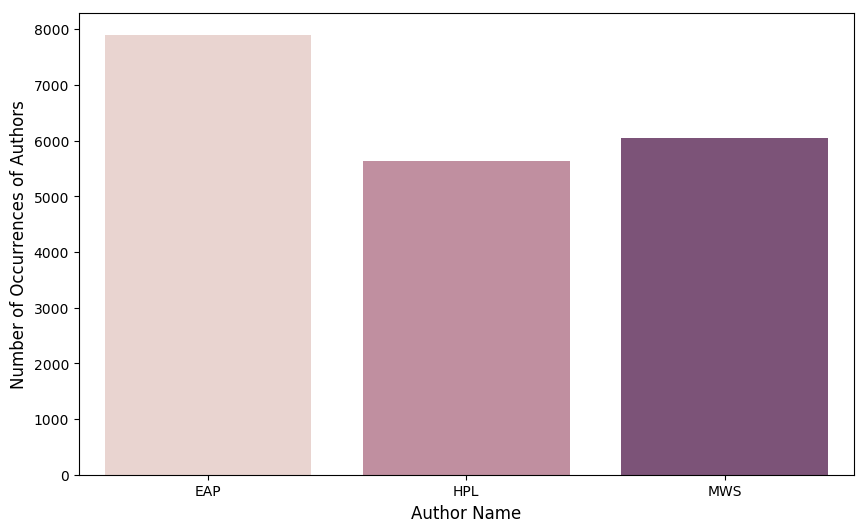

In [275]:
author_text_count = pd.DataFrame(train.groupby('author')['text'].count())
author_text_count.reset_index(inplace = True)

plt.figure(figsize=(10,6))

sns.barplot(author_text_count.author, author_text_count.text, palette=sns.cubehelix_palette(4))
plt.ylabel('Number of Occurrences of Authors', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

### b) Top 50 (Uncleaned) Word frequencies in the training dataset

These words actually do not tell us much about the themes and concepts that all the authors wants to portray to the reader in their stories

These words are all so commonly occuring words which you could find just anywhere else. Not just in spooky stories and novels by our three authors but also in newspapers, kid book, religious texts - really almost every other english text. Therefore i must find some way to preprocess our dataset first to strip out all these commonly occurring words which do not bring much to the table.

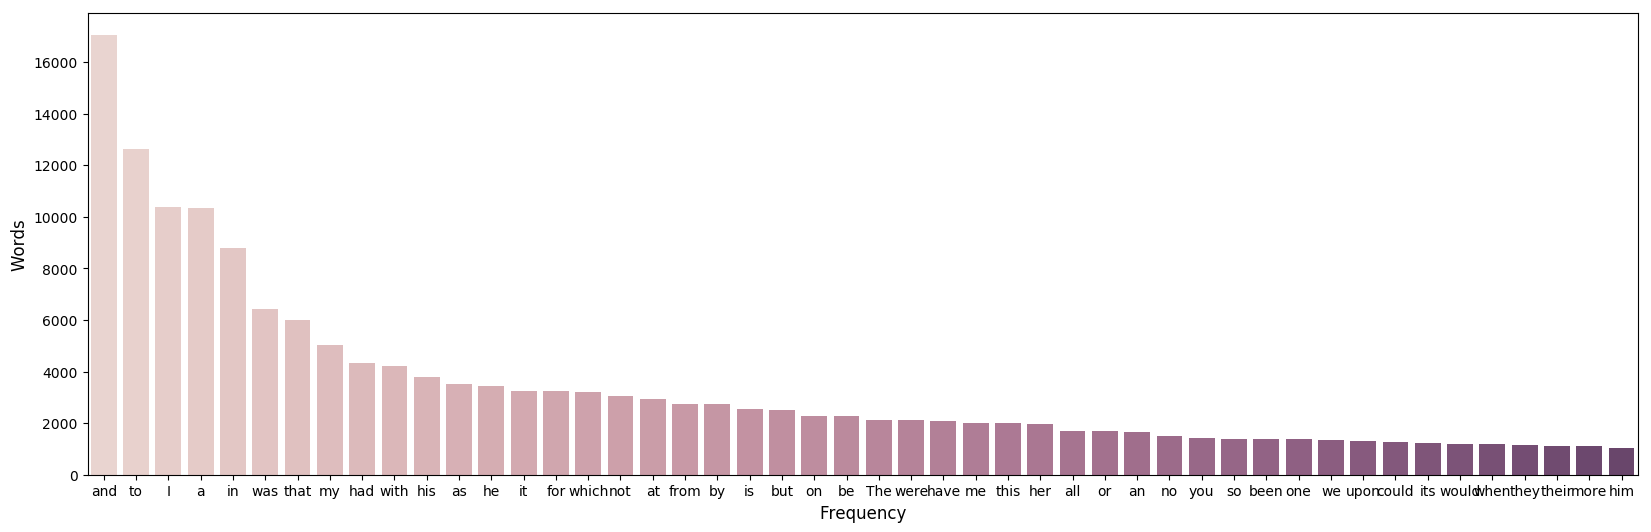

In [272]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()

words_index = all_words.index.values[2:50]
words_values = all_words.values[2:50]

plt.figure(figsize=(20,6))

sns.barplot(words_index, words_values, palette=sns.cubehelix_palette(64))
plt.ylabel('Words', fontsize=12)
plt.xlabel('Frequency', fontsize=12)
plt.show()

### c) Wordcloud

There are three separate word clouds, one for each of the spooky authors. You can see from these word clouds some of the choice words that were favoured by the different authors.

For example, you can see the HP lovecraft favours words like "dream", "time", "strange", "dark", "ancient", "night" which seem to resonate with themes around the hidden psyche and esoteric nature of fate and chance as well as the infamous Cthulhu and mentions of ancient cults associated with it.

On the other hand, one can see that Mary Shelley's words revolve around primal instincts and themes of morality which range from the positive to negative ends of the spectrum, such as "friend", "fear", "hope", "spirit", "heart", "love" etc.

However, as you can see from the word clouds, there are still a handful of words that seem to be quite out of place. Words such as "us", "go", "he" which seem to appear commonly every where in text

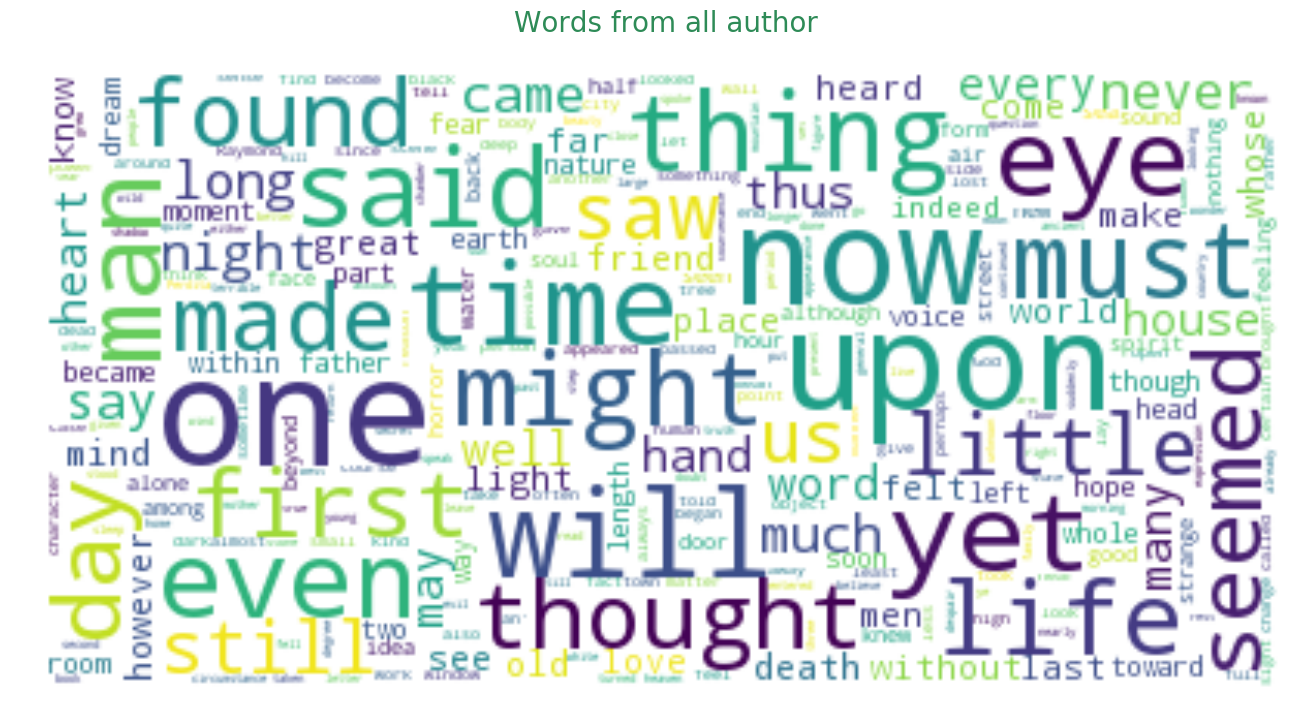

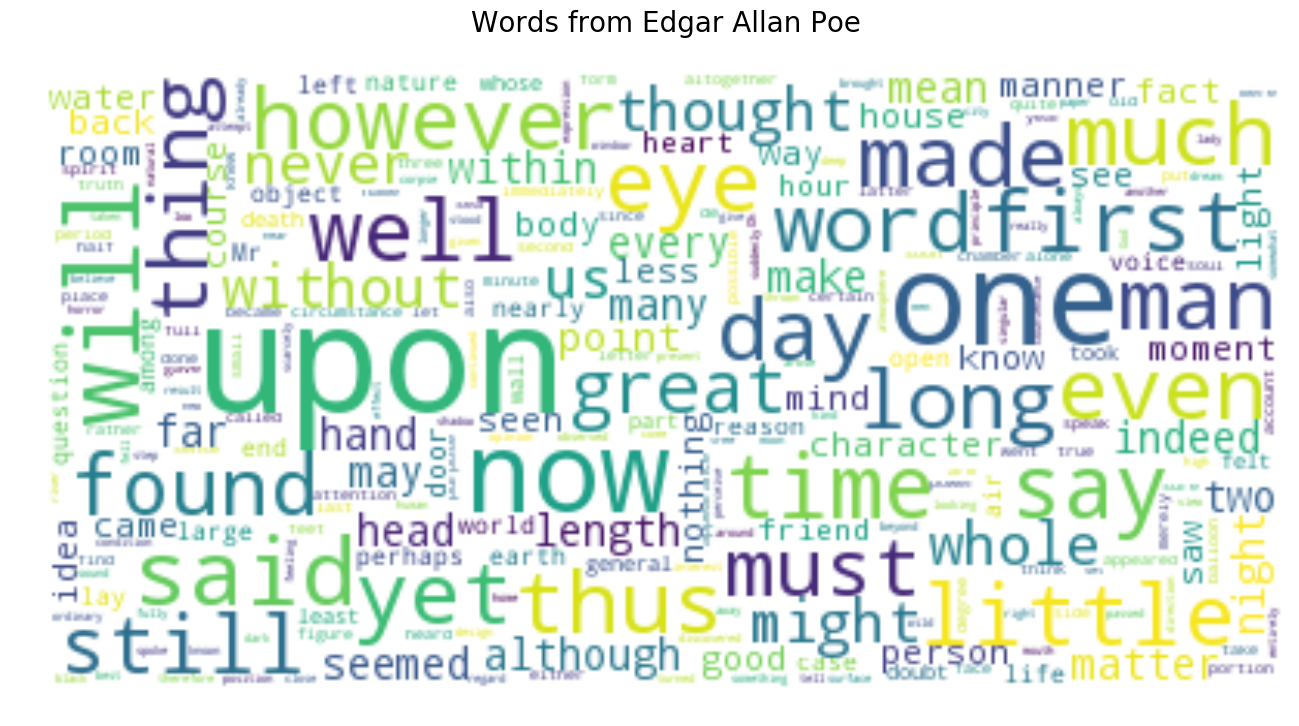

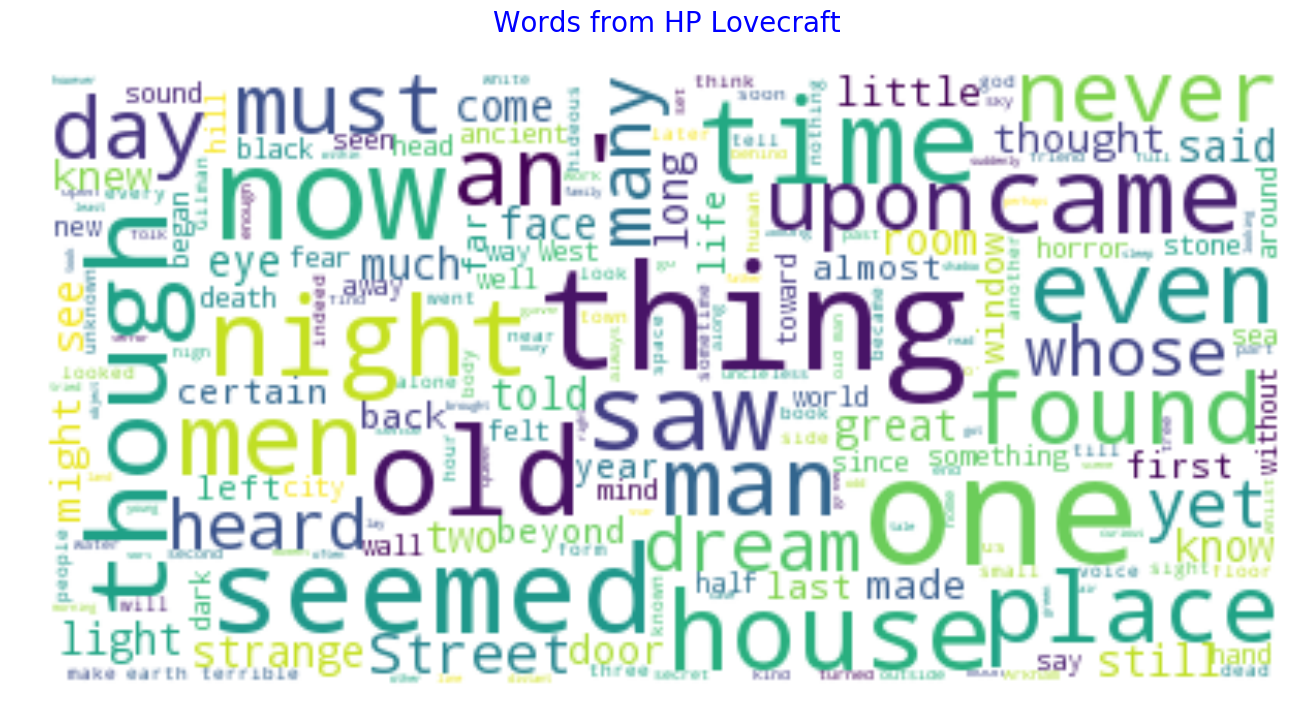

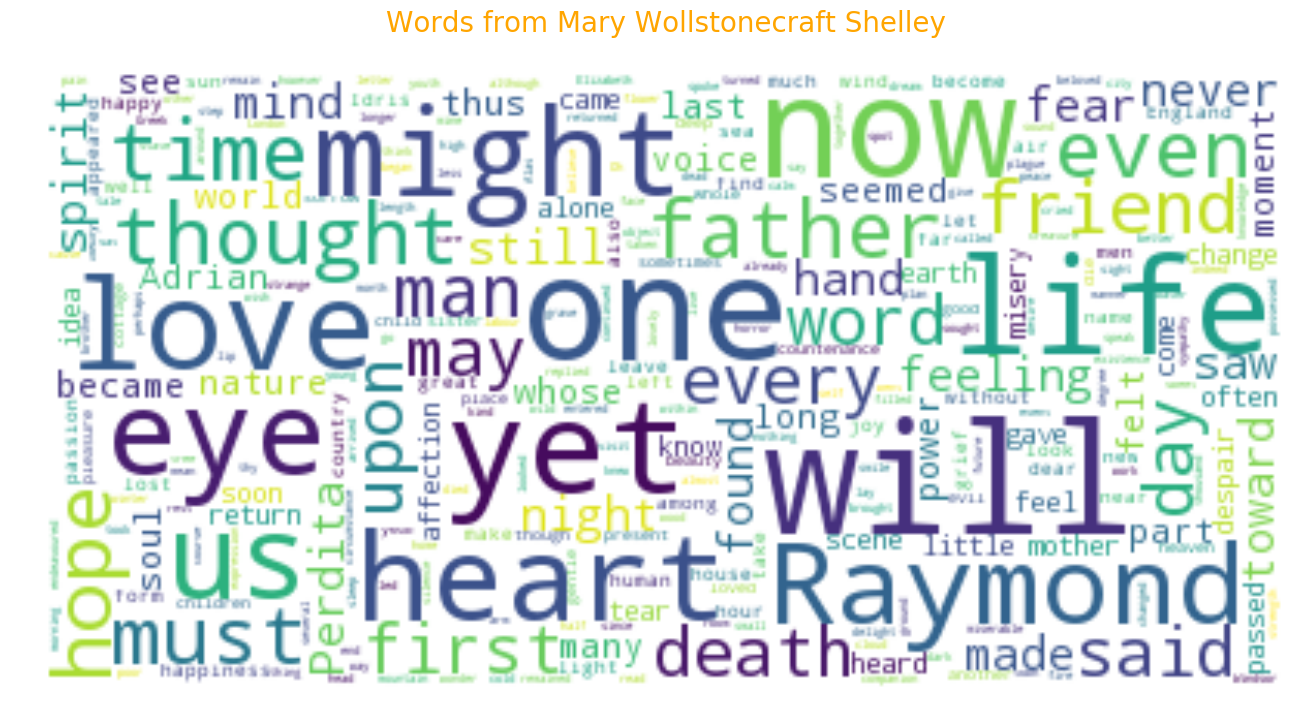

In [259]:
import codecs

import sys
reload(sys)
sys.setdefaultencoding('utf-8')


wc = WordCloud(background_color="white", max_words=5000, 
               stopwords=STOPWORDS, max_font_size= 50)
# generate word cloud for all authors
wc.generate(" ".join(train.text))

# show
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Words from all author" + "\n", fontsize=20,color='seagreen')
plt.axis("off")
plt.show(wc)


eap = train[train.author=="EAP"]["text"].values
hpl = train[train.author=="HPL"]["text"].values
mws = train[train.author=="MWS"]["text"].values


# generate word cloud for Edgar Allan Poe

wc.generate(" ".join(eap))

# show
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Words from Edgar Allan Poe" + "\n", fontsize=20,color='black')
plt.axis("off")
plt.show(wc)

# generate word cloud for HP Lovecraft

wc.generate(" ".join(hpl))

# show
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Words from HP Lovecraft" + "\n", fontsize=20,color='blue')
plt.axis("off")
plt.show(wc)

# generate word cloud for Mary Wollstonecraft Shelley

wc.generate(" ".join(mws))

# show
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.title("Words from Mary Wollstonecraft Shelley" + "\n", fontsize=20,color='orange')
plt.axis("off")
plt.show(wc)

### d) Distribution of average words in text for each author 

It can be clearly seen that most of the texts given in the training dataset have word count from 0 to ~100, but the distribution is diferent in right portion of histograms. 
HP lovecrafts's text are less scattered, followed by EAP's, and Mary Sheley's text few texts has length ~900 too. 
This information can be used in hand designed features, for example we can make feature of 0/1 if text is greater than 250 or not, or we can make bins and use this feature, this will sure help in classification of Mary Shelley.

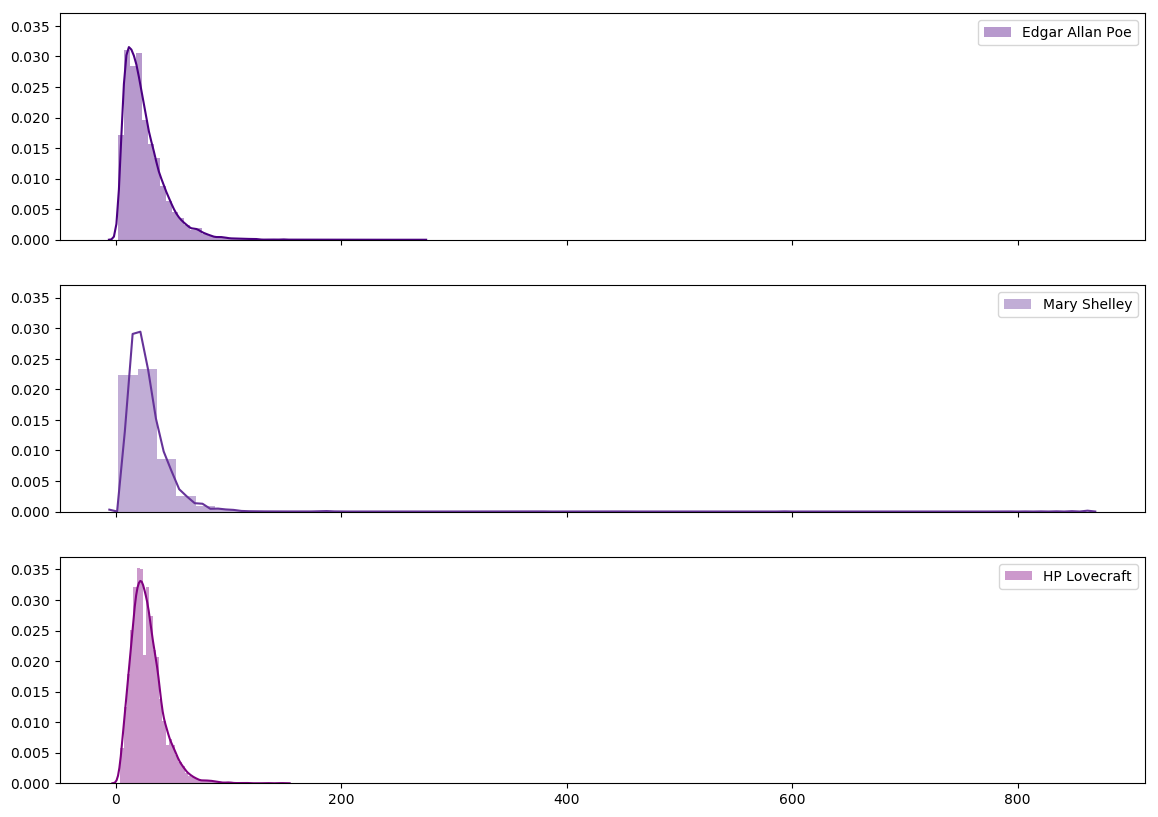

In [281]:
# Lets check the avg number of words in text written by each author in a histogram 
def word_count(row):
    """function to calculate the count of words in a given text """
    text = row['text']
    text_splited = text.split(' ')
    word_count = text_splited.__len__()
    return word_count

train['word_count'] = ''
train['word_count'] = train.apply(lambda row: word_count(row), axis =1)
test['word_count'] = test.apply(lambda row: word_count(row), axis =1)

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(14,10))
sns.distplot(train.loc[train['author']=='EAP']['word_count'].values, ax=ax[0], color='indigo', label='Edgar Allan Poe')
sns.distplot(train.loc[train['author']=='MWS']['word_count'].values, ax=ax[1], color='rebeccapurple', label='Mary Shelley')
sns.distplot(train.loc[train['author']=='HPL']['word_count'].values, ax=ax[2], color='purple', label='HP Lovecraft')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
ax[2].legend(loc=0)
plt.show()


<a id='dp'></a>

## 6) Data Preprocessing

### Text cleaning 

1) Converting the entire text into lower case 2) Removing punctuation 3) Truncating the spaces 4) Removing Stop words 5) Lemmatization 

In [12]:
from nltk import word_tokenize

for token in train: 
    def tokenize(text):
        text = text.decode('utf-8').encode('ascii', 'ignore')
        words = word_tokenize(text) #split words
        words = [w.lower() for w in words if w.isalpha()] #get rid of punctuation
        words =[w for w in words if  not w in STOPWORDS]
        stemmed = [porter.stem(w) for w in words]
        stemmed = ' '.join(w for w in stemmed)
        return stemmed
train['tokens'] = train['text'].apply(tokenize)

In [283]:
train.head()

,id,text,author,word_count,tokens
0,id26305,"This process, however, afforded me no means of...",EAP,41,process howev afford mean ascertain dimens dun...
1,id17569,It never once occurred to me that the fumbling...,HPL,14,never occur fumbl might mere mistak
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,left hand gold snuff box caper hill cut manner...
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,love spring look windsor terrac sixteen fertil...
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,find noth even gold superintend abandon attemp...


<a id='calgo'></a>

## 6) Classification Algorithms

The Naive Baye's classifier works well in the case of identifying the author with the accuracy of 80.7% on the validation data. It tends to classify most of the text correctly.

The most frequently occuring class in this dataset is EAP followed by MWS. It is very likely that the models will be able to identify the text of EAP mostly as EAP's but the text of HPL can be confused with the other authors since it has less data points in the training set.

The confusion matrix clearly shows that Naive Baye's is able to coorectly classify the text and assign it to correct author.

### a) Splitting train data into training and valid set

In [13]:
train,valid = train_test_split(train,test_size=0.33,random_state=42)

###  b) Baseline model

In [176]:
folds = StratifiedKFold(shuffle=True, n_splits=10, random_state=10)
baseline = make_pipeline(CountVectorizer(analyzer=identity), DummyClassifier('most_frequent'))
base_score = cross_val_score(baseline, train['tokens'], train['author'], cv=folds)
base_score.mean(), base_score.std()

(0.4050468857521059, 8.189632987091868e-05)

### c) Simple logistic regression

In [194]:
lr = make_pipeline(CountVectorizer(analyzer=identity), LogisticRegression())
lr_score = cross_val_score(lr,train['tokens'], train['author'], cv=folds)
lr_score.mean(), lr_score.std()

(0.4840984918335918, 0.016387722550083018)

#### i) Finding best parameters for logistic regression

In [184]:
#Pipeline for logistics regression
best_lr = make_pipeline(CountVectorizer(analyzer=identity), 
                       TfidfTransformer(),
                       LogisticRegression())

params = {'logisticregression__penalty': ['l2'],
          'tfidftransformer__norm': ['l2', None],
          'tfidftransformer__use_idf': [True, False],
          'tfidftransformer__sublinear_tf': [True, False],
          'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10.0],
          'countvectorizer__min_df': [1, 2, 5],
          'countvectorizer__max_df': [0.1, 0.25, 0.5, 0.75, 1.0]}
grid_search = GridSearchCV(best_lr, params, n_jobs=-1, verbose=1, return_train_score=True)
grid_search.fit(train['tokens'], train['author'])

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=1,  # min count for relevant vocabulary
    max_features=4000,  # maximum number of features
    strip_accents='unicode',  # replace all accented unicode char 
    # by their corresponding  ASCII char
    analyzer='word',  # features made of words
    token_pattern=r'\w{1,}',  # tokenize only words of 4+ chars
    ngram_range=(1, 1),  # features made of a single tokens
    use_idf=True,  # enable inverse-document-frequency reweighting
    smooth_idf=True,  # prevents zero division for unseen words
    sublinear_tf=False)

tfidf_df = tfidf_vectorizer.fit_transform(train['author'])
tfidf_vectorizer.get_feature_names()


Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 23.1min finished
C:\Users\nikit\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


[u'eap', u'hpl', u'mws']

In [185]:
grid_search.best_params_

{u'countvectorizer__max_df': 1.0,
 u'countvectorizer__min_df': 1,
 u'logisticregression__C': 1.0,
 u'logisticregression__penalty': u'l2',
 u'tfidftransformer__norm': u'l2',
 u'tfidftransformer__sublinear_tf': False,
 u'tfidftransformer__use_idf': True}

In [15]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

In [193]:
best_lr.set_params(**grid_search.best_params_)
score  = cross_val_score(best_lr, train['tokens'], train['author'],cv=folds, n_jobs=-1)
score.mean(), score.std()

(0.4834105415518487, 0.018328883588549266)

#### ii) Predicting Logistic Regression on validation set

In [214]:
best_lr.fit(train['tokens'], train['author'])

lr_predicted = best_lr.predict(list(valid['tokens']))
float(np.mean(lr_predicted == valid['author']))

0.47647787062828845

#### iii) Confusion Matrix for Logistic regression

In [301]:
import itertools
from sklearn.metrics import confusion_matrix

### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

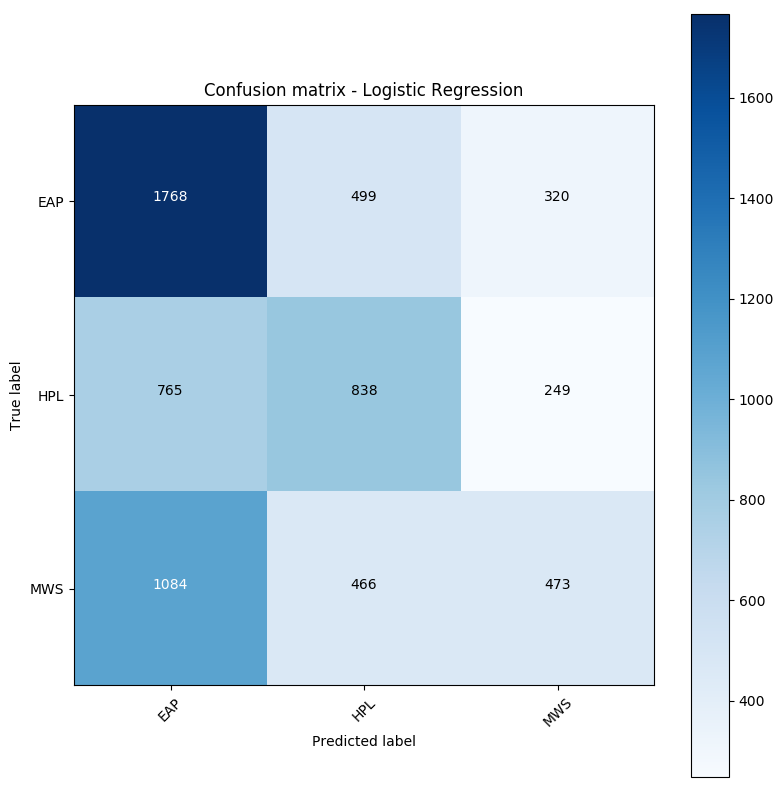

In [302]:
cnf_matrix = confusion_matrix(valid['author'], lr_predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix - Logistic Regression')
plt.show()

### c) SVM

In [179]:
#svm.SVC()
from sklearn import svm

svm_n = make_pipeline(CountVectorizer(analyzer=identity), svm.SVC())
svm_n_score = cross_val_score(svm_n,train['tokens'], train['author'], cv=folds)
svm_n_score.mean(), svm_n_score.std()

(0.465964907479311, 0.014519257528290844)

#### i) Finding best parameters for SVM

In [207]:
from sklearn.pipeline import Pipeline

parameters = {'kernel':('linear', 'rbf'), 'C':[1,4,7,10], 'gamma': 
              [0.01,0.04,0.10,0.5]}
svr = svm.SVC()
clf_svm1 = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()), ('grid',  GridSearchCV(svr, parameters))])
_ = clf_svm1.fit(list(train['tokens']), list(train['author']))

#### ii) Predicting SVM on validation set

In [211]:
svm_predicted = clf_svm1.predict(list(valid['tokens']))
float(np.mean(svm_predicted == valid['author']))

0.7961931290622098

#### iii) Confusion Matrix for SVM

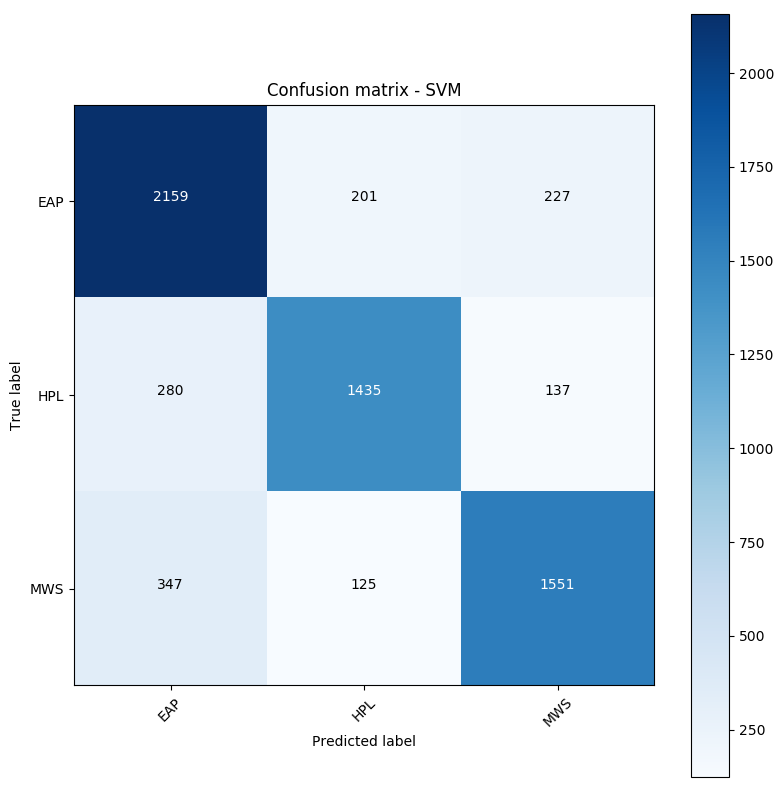

In [303]:
cnf_matrix = confusion_matrix(valid['author'], svm_predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix - SVM')
plt.show()

### d) Naive Baye's

In [16]:
from sklearn.naive_bayes import MultinomialNB

mnb_n = make_pipeline(CountVectorizer(analyzer=identity), MultinomialNB())
mnb_n_score = cross_val_score(mnb_n,train['tokens'], train['author'], cv=folds)
mnb_n_score.mean(), mnb_n_score.std()

(0.4648405855691262, 0.014843240250966382)

#### i) Finding best parameters for Naive Baye's

In [17]:
# TFIDF model
tfidf = TfidfTransformer()

#vector count model
vector= CountVectorizer(decode_error = 'ignore',stop_words = 'english')
# fit and transform the training set
X_train = vector.fit_transform(list(train['tokens']))
X_train_tfidf = tfidf.fit_transform(X_train)
y_train = list(train['author'])

#transform the testing set with the training model
X_test = vector.transform(list(valid['tokens']))
X_test_tfidf= tfidf.transform(X_test)
y_test = list(valid['author'])

C:\Users\nikit\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


#### ii) Predicting NB on validation set

In [20]:
clf_nb = MultinomialNB().fit(X_train, y_train)
nb_predicted = clf_nb.predict(X_test_tfidf)
float(np.mean(nb_predicted == y_test))

0.8073458073458073

#### iii) Confusion Matrix for NB

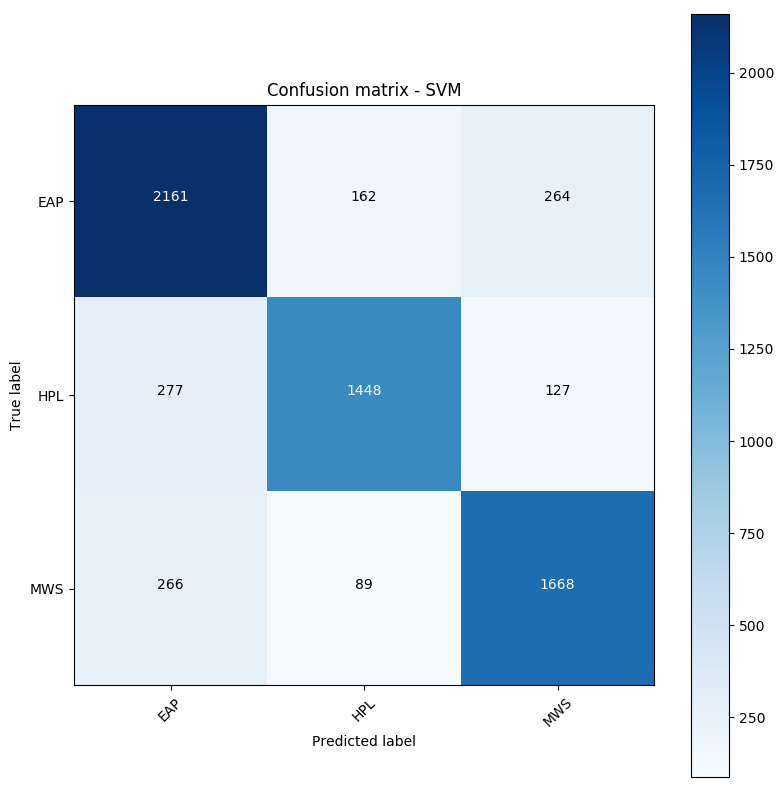

In [304]:
cnf_matrix = confusion_matrix(valid['author'], nb_predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix - SVM')
plt.show()

<a id='test'></a>

## 7) Testing best model(NB) on Unlabeled data

I randomly tested the best model(NB) on unlabeled dataset or the test data that was provided. 
After testing it, i saw that the model was able to classify two texts correctly, whereas for one text it missclasified the text to be written by EAP instead of HPL.

Following links contain the tested texts for the two authors,

Edgar Allen Poe -> http://xroads.virginia.edu/~hyper/poe/phall.html

HP Lovecraft -> http://www.hplovecraft.com/writings/texts/fiction/f.aspx

In [36]:
# Test the model on the test data.

def test_sample(model, sample):
    sample_counts = vector.transform([sample])
    sample_tfidf = tfidf.transform(sample_counts)
    result = model.predict(sample_tfidf)[0]
    prob = model.predict_proba(sample_tfidf)[0]
    print("Author of this sentence is %s" % (result.upper()))

test_sample(clf_nb, "If a fire wanted fanning, it could readily be fanned with a newspaper, and as the government grew weaker, I have no doubt that leather and iron acquired durability in proportion, for, in a very short time, there was not a pair of bellows in all Rotterdam that ever stood in need of a stitch or required the assistance of a hammer.")
test_sample(clf_nb, "And then, because that nightmare's position barred me from the stone staircase down which we had come, I flung myself into the oily underground river that bubbled somewhere to the caves of the sea; flung myself into that putrescent juice of earth's inner horrors before the madness of my screams could bring down upon me all the charnel legions these pest gulfs might conceal.")
test_sample(clf_nb, "At his nod I took one of the latter and seated myself upon an aged, discoloured gravestone close by the newly uncovered aperture.")

Author of this sentence is EAP
Author of this sentence is HPL
Author of this sentence is EAP
